In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
from skimage import data
from skimage import filters, io
from skimage.filters import try_all_threshold
from scipy import ndimage as ndi
from scipy import stats
import numpy as np
import glob

In [4]:
x_data = []
y_data = []
Fonts = [ 'IBM Plex Sans Arabic', 'Lemonada', 'Marhey','Scheherazade New'] 

for font in Fonts:
    for filename in sorted(glob.glob(f'./fonts-dataset/{font}/*.jpeg')):
       img =ski.io.imread(filename)   
       filtered_img = ski.filters.median(img,mode='nearest')
       grayImg = ski.color.rgb2gray(filtered_img)
       thresh= ski.filters.threshold_otsu(grayImg)#neb2a nshof meen
       binary = grayImg < thresh
       binaryImg = img = ski.util.img_as_ubyte(binary)
       black_pixels = np.sum(binaryImg == 0)
       total_pixels = binaryImg.size
       percentage_black = (black_pixels / total_pixels) * 100

       if percentage_black > 50:
         inverted_binaryImg = np.where(binaryImg == 0, 255, 0)
       else:
          inverted_binaryImg = binaryImg

       inverted_binaryImg = ski.util.img_as_ubyte(inverted_binaryImg)
       x_data.append(inverted_binaryImg)                                  ## add the image to x_data
       y_data.append(Fonts.index(font))  
       
x_data = np.asarray(x_data)
y_data = np.asarray(y_data)


print("shape of x_data:", x_data.shape, "shape of y_data:", y_data.shape)

c:\Users\Momo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\util\dtype.py:576: UserWarning: Downcasting int32 to uint8 without scaling because max value 255 fits in uint8
  return _convert(image, np.uint8, force_copy)


shape of x_data: (4000, 1181, 1181) shape of y_data: (4000,)


In [5]:
import cv2
import os
import numpy as np

# Assuming preprocessed_images is a list of your preprocessed images
preprocessed_images = x_data

# Specify the directory you want to save the images in
save_dir = "preprocessed_images"

# Make sure the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Loop through your preprocessed images
for i, img in enumerate(preprocessed_images):
    # Convert the image to uint8
    img_uint8 = (img).astype(np.uint8)
    
    # Define the name of the file
    filename = os.path.join(save_dir, f"{y_data[i]}_{i}.jpg")
    
    # Save the image
    cv2.imwrite(filename, img_uint8)

In [3]:
import cv2
import os
import numpy as np

# Specify the directory where your preprocessed images are saved
img_dir = "preprocessed_images"

# Get the list of image file names
img_files = os.listdir(img_dir)

# Initialize an empty list to store the images
x_data = []
y_data = []

# Loop through the image files
for img_file in img_files:
    # Construct the full path of the image file
    img_path = os.path.join(img_dir, img_file)
    
    # Read the image using cv2.imread
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Use cv2.IMREAD_COLOR for color images
    
    # Append the image to x_data
    x_data.append(img)
    label=img_file.split('_')[0]
    y_data.append(label)

# Convert x_data to a numpy array
x_data = np.array(x_data)
y_data = np.array(y_data) 

# Now you can use x_data in your code
p = np.random.permutation(len(x_data))
x_data = x_data[p]
y_data = y_data[p]
del img_files


In [9]:
from tqdm import tqdm
from cv2 import resize, xfeatures2d
import skimage as ski
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import svm

sift = cv2.SIFT_create()
sift_features = []
hog_features = []

batch_size = 100  # Adjust this based on your available memory
num_batches = len(x_data) // batch_size

for i in tqdm(range(num_batches + 1), desc="Processing batches"):  # +1 to include the last batch
    start = i * batch_size
    end = min(start + batch_size, len(x_data))  # Ensure the end index doesn't exceed the number of images
    batch = x_data[start:end]
    
    for image in batch:
        # Resize the image
        # image = resize(image, (400, 350))
        
        # Apply HOG feature extraction
        hog_feat = ski.feature.hog(image, orientations=15, pixels_per_cell=(32,32), cells_per_block=(1, 1), block_norm='L2')
        
        # # Apply SIFT feature extraction
        # _, sift_feat = sift.detectAndCompute(image, None)
        
        # if sift_feat is None:
        # # # Create a zero-filled array of the appropriate size
        #  sift_feat = np.zeros((1, sift.descriptorSize()))

        # Append the features to the respective lists
        # sift_features.append(sift_feat.ravel())  # ravel() flattens the array
        hog_features.append(hog_feat)



# # Find the maximum length of the feature vectors
# max_length = max(len(feat) for feat in sift_features)

# # Pad the feature vectors with zeros
# sift_features_padded = [np.pad(feat, (0, max_length - len(feat))) for feat in sift_features]
scaler = StandardScaler()
# Convert lists to numpy arrays after all batches have been processed
# sift_features_padded = np.array(sift_features_padded)
# hog_features = np.array(hog_features)

# Concatenate the features horizontally


Processing batches: 100%|██████████| 41/41 [09:11<00:00, 13.44s/it]


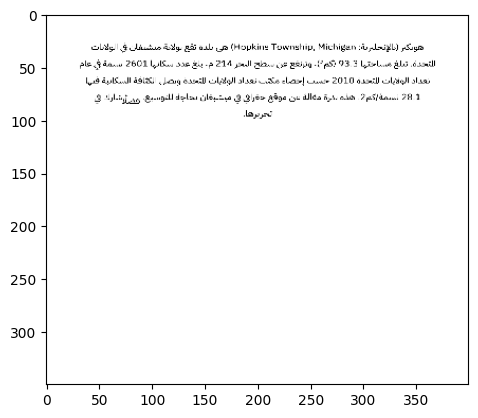

In [8]:
# plot the first image in the data set
plt.imshow(resize(x_data[0],(400,350)), cmap='gray')

In [11]:
hog_features = np.hstack([hog_features])
normalized_features = scaler.fit_transform(hog_features)
#save the features
np.save('hog_features.npy', normalized_features)

del sift_features, x_data , hog_features

In [ ]:
from sklearn.model_selection import train_test_split

# First split the data into a training set and a temporary set using a 70-30 split
x_train, x_val, y_train, y_val = train_test_split(normalized_features, y_data, test_size=0.3, random_state=22, stratify=y_data)

# Then split the temporary set into a validation set and a test set using a 50-50 split


print("shape of x_train:", x_train.shape, "shape of y_train:", y_train.shape)
print("shape of x_val:", x_val.shape, "shape of y_val:", y_val.shape)

del normalized_features, y_data

shape of x_train: (2800, 95040) shape of y_train: (2800,)
shape of x_val: (1200, 95040) shape of y_val: (1200,)


In [ ]:
from sklearn.decomposition import PCA

# Create a PCA object
pca = PCA(n_components=0.9999)  # Adjust this to the desired number of components or variance to retain

# Fit the PCA model and transform the data
features_pca = pca.fit(x_train)
features_pca = pca.transform(x_train)

del x_train


In [ ]:
# Encode the labels to integers
le = LabelEncoder()
y_data_encoded = le.fit_transform(y_train[:len(features_pca)])  # Ensure the number of labels matches the number of features

# Create an SVM classifier with gamma='scale' and C=1
clf = svm.SVC(gamma='scale', C=6.4)

# Fit the classifier on the data
clf.fit(features_pca, y_data_encoded)

del features_pca, y_data_encoded

# Now the SVM model is trained and ready to make predictions

In [ ]:
from sklearn.metrics import accuracy_score# Apply PCA
features_pca = pca.transform(x_val)

# Encode the validation labels
y_val_encoded = le.transform(y_val)

# Use the trained SVM model to make predictions on the validation set

y_pred = clf.predict(features_pca)

# Compute the accuracy of the predictions
accuracy = accuracy_score(y_val_encoded, y_pred)

print(f"Validation accuracy: {accuracy * 100:.2f}%")

Validation accuracy: 78.42%


In [ ]:
features_pca.shape

(1200, 2783)